# John Wu
# CSE 5524
# 10/1/22
### Libraries

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
from skimage import morphology
# plt.rcParams['figure.figsize'] = [20, 20]

### 1) Use the covariance matching technique to find the correct match in the color image given on the WWW site (target.jpg). The model covariance matrix (of <x,y,R,G,B> features) is given below (notice x,y vs. row,col!). modelCovMatrix = [47.917 0 -146.636 -141.572 -123.269; 0 408.250 68.487 69.828 53.479; -146.636 68.487 2654.285 2621.672 2440.381; -141.572 69.828 2621.672 2597.818 2435.368; -123.269 53.479 2440.381 2435.368 2404.923]; Test all possible overlapping windows (each of size 70 rows by 24 columns, with the upperleft-corner as the window origin) in the image with the given model. Save the match distance for each box location in the image at each pixel location (for the origin of the window). Plot/display the match-distance-image. Provide the location of the best match distance for the best candidate. Note that the above given covariance matrix is biased (normalized with 1/(M*N)), and Matlab’s cov function is unbiased by default using 1/(M*N-1), so call cov( X, 1 ) to make it consistent (biased). Leave the image with colors ranging 0-255 (do not scale/normalize the colors). NOTE: make sure not to take a log() of zero at any time! [5 pts]

In [28]:
modelCovMatrix = np.loadtxt('modelCovMatrix.txt')
targetIm = plt.imread("target.jpg")
windowRows = 70
windowCols = 24
currentOriginRow = 0
currentOriginCol = 0
print(modelCovMatrix)
print("dimensions of targetIm:", targetIm.shape)

[[  47.917    0.    -146.636 -141.572 -123.269]
 [   0.     408.25    68.487   69.828   53.479]
 [-146.636   68.487 2654.285 2621.672 2440.381]
 [-141.572   69.828 2621.672 2597.818 2435.368]
 [-123.269   53.479 2440.381 2435.368 2404.923]]
dimensions of targetIm: (240, 320, 3)


In [29]:
# Define a bunch of important functions
def rieman_manifold(cModel, cCandidate):
    genEig, genEigVector = scipy.linalg.eig(cModel, cCandidate)
    genEig = np.log(genEig)
    genEig = np.square(genEig)
    sumCost = np.sum(genEig)
    sumCost = np.sqrt(sumCost)
    return sumCost

# note one key issue of python vs. matlab is again, we have to worry about starting row and column = 1
def compute_covariance(im, originRow, originCol, windowRows, windowCols):
    # 5 features.
    X = np.zeros((windowRows * windowCols,5))
    i = 0 # I'm too lazy to do row colum arithmetic 
    for row in range(originRow, originRow + windowRows): # rows are Y
        for col in range(originCol, originCol + windowCols): # columns are X
            X[i,0] = col + 1 # notice that we need to add 1 to match matlab values
            X[i,1] = row + 1  # y
            X[i,2] = im[row, col, 0] # R
            X[i,3] = im[row, col, 1] # G
            X[i,4] = im[row, col, 2]  # B
            i+=1
    cov = np.cov(np.transpose(X), bias=True) # add bias back in.
    return cov


In [30]:
# now let's slide the window across and scan
def covariance_track(im, modelCovMatrix, windowRows, windowCols):
    finalOriginRow = im.shape[0] - windowRows + 1
    finalOriginCol = im.shape[1] - windowCols + 1
    bestOriginRow = 0
    bestOriginCol = 0
    bestDistance = np.Inf
    matchDistances = np.zeros((finalOriginRow, finalOriginCol))
    for row in range(finalOriginRow):
        for col in range(finalOriginCol):
            candidateCovMatrix = compute_covariance(im, row, col, windowRows, windowCols)
            matchDistance = rieman_manifold(modelCovMatrix, candidateCovMatrix)
            matchDistances[row, col] = matchDistance
            if matchDistance < bestDistance:
                bestOriginRow = row
                bestOriginCol = col
                bestDistance = matchDistance
    return matchDistances, (bestOriginRow, bestOriginCol) # return a matrix of all the distances and best row/col
        

In [31]:
matchDistances, bestOrigin = covariance_track(targetIm, modelCovMatrix, windowRows, windowCols)

C:\Users\jhnwu\AppData\Local\Temp/ipykernel_14260/4159404938.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  matchDistances[row, col] = matchDistance


(23, 251)


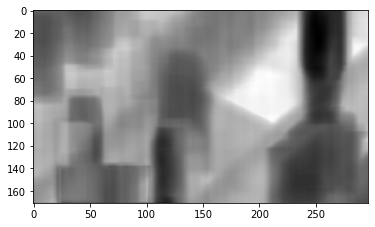

In [32]:
print(bestOrigin)
np.savetxt('p1_matchdistances.txt', matchDistances) # save all distances as well as plot it
plt.imsave('p1_matchdistances.png', matchDistances, cmap='gray') 
plt.imshow(matchDistances, cmap='gray') # bright spots equal greater distances, dark spots 

##### Location of best origin match is at (row, col) = (23,251) or (X,Y) = (251, 23), which is the big dark spot in the match distances above! Note that in matlab, these indices would be increased by 1, so it would be (24,252) in Matlab. We will now plot and save the window of interest.

##### Original:

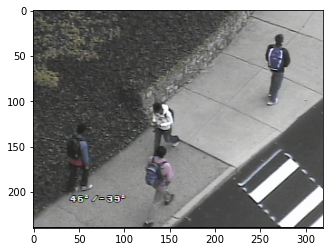

In [33]:
plt.imshow(targetIm)

##### Model Covariance Matrix Image From Origin

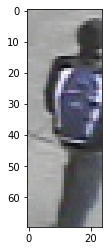

In [34]:
plt.imshow(targetIm[bestOrigin[0]:bestOrigin[0] + windowRows, bestOrigin[1]:bestOrigin[1] + windowCols])
plt.imsave('p1_target_model.png',targetIm[bestOrigin[0]:bestOrigin[0] + windowRows, bestOrigin[1]:bestOrigin[1] + windowCols] )

##### Quick Discussion: The match distances displayed above provide a pretty awesome way of seeing what the model thinks it's supposed to be tracking. In this case, it zooms in on the blue backpack, but other lower match distances are also centered around all the other people. This makes sense if the model is of a person and their backpack as the colors of people are different than the colors of a sidewalk or tree.



#

### 2) Create a function to extract a feature vector of pixel information in a circular neighborhood (< radius) around (x,y): [ X ]=circularNeighbors(img, x, y, radius); For each pixel, use the same format to return as used above (<xi ,yi ,R,G,B>). That is, X should be a Kx5 matrix, where each row is for one of the pixels in the neighborhood. Assume that the (x,y) passed into the function are real (non-integer) values, and do NOT round them in the function for computation of the neighborhood. [2 pts]

In [35]:
def pixelFeature(im, row, col): # reminder row = y, column = x
    x = np.zeros(5)
    x[0] = col
    x[1] = row 
    x[2] = im[row,col,0] # R
    x[3] = im[row,col,1] # G
    x[4] = im[row,col,2] # B
    return x

# centerX ~ col, centerY ~ row
def radialDistance(centerX, centerY,x,y):
    return np.sqrt( np.square(centerX - x) + np.square(centerY - y))

# Epanchnikov profile, also again, x is a column, y is a row (BE VERY CAREFUL)
def circularNeighbors(img, x, y, radius):
    neighborhood = [] # we will append and then  return a matrix.
    maxY = y + radius # max row 
    minY = y - radius # minimum row
    maxX = x + radius # maximum col we're seaching
    minX = x - radius # min col
    # in case we run into weird boundaries of images
    minY = int(minY) - 1
    maxY = int(maxY) + 1
    minX = int(minX) - 1
    maxX = int(maxX) + 1
    if minY < 0:
        minY = 0
    if maxY > img.shape[0]:
        maxY = img.shape[0]
    if minX < 0:
        minX = 0
    if maxX > img.shape[1]:
        maxX = img.shape[1]
    
    # note that the way this neighborhood matrix will be sorted from top
    # to bottom, left to right. We do the above to reduce computational time.
    for row in range(minY, maxY): # y are the rows
        for col in range(minX, maxX): # again X are the columns
            if radialDistance(centerX=x,centerY=y,x=col,y=row) < radius:
                # returns <x,y,r,g,b>
                neighborFeatures = pixelFeature(img, row, col)
                neighborhood.append(neighborFeatures)
    neighborhood = np.stack(neighborhood, axis=0)
    return neighborhood

    

In [36]:
radialTestMat = np.ones((5,5,3))
testNbrHd = circularNeighbors(radialTestMat,2.5,2, 2)
print("Sanity Check Test Dims:",testNbrHd.shape)
print(testNbrHd)

Sanity Check Test Dims: (12, 5)
[[1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1.]
 [3. 1. 1. 1. 1.]
 [4. 1. 1. 1. 1.]
 [1. 2. 1. 1. 1.]
 [2. 2. 1. 1. 1.]
 [3. 2. 1. 1. 1.]
 [4. 2. 1. 1. 1.]
 [1. 3. 1. 1. 1.]
 [2. 3. 1. 1. 1.]
 [3. 3. 1. 1. 1.]
 [4. 3. 1. 1. 1.]]


##### Quick note: Test results above makes sense given location of the center. 

### 3) Create a function to build a color histogram from the neighborhood info: [ hist ]=colorHistogram(X, bins, x, y, h); The histogram (hist) should be a bins x bins x bins color cube (RxGxB). The bins should be evenly spaced. For example, if bins=4 then the pixel-value limits for each bin will be {0-63, 64-127, 128-191, 192-255}. Be sure to test your code on pixels with possible RGB values of 0 and 255. Weight the construction of the histogram using an Epanechnikov kernel centered at real-valued (x, y) and with bandwidth h. Normalize the histogram/cube so it sums to 1. (This function will be used to make your model histogram “q_model” and to make the candidate test histogram “p_test”) [3 pts]

In [37]:
def epKernel(centerX, centerY, x, y, h):
    r = np.sqrt(np.square(centerX - x) + np.square(centerY - y)) / h
    r = np.square(r)
    retVal = 0
    if r < 1:
        retVal = 1 - r
    return retVal

def colorHistogram(X, bins, x, y, h):
    hist = np.zeros((bins,bins,bins)) # CUBE OF BINS for RGB
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now go through all the pixel values in X, and bin them. 2 for the position x,y
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if (X[i,color] >= binLowerBounds[bin]) and (X[i,color] <= binUpperBounds[bin]): 
                    rgbBins[color - 2] = bin # tldr; find bin for rgb colors.
        # once binned, then, add their weighted values given center
        # using Epanechnikov kernel
        # since we defined which ones exist already, we can just add those specifically.
        hist[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])] += epKernel(x,y,X[i,0],X[i,1],h)
    hist /= np.sum(hist) # normalize
    return hist
    

##### We will test the above function in the later sections.

### 4) Create a function to calculate a vector of the mean-shift weights (w), where there is a weight w i for each pixel i in the neighborhood: [2 pts] [ w ]=meanshiftWeights(X, q_model, p_test, bins);

In [38]:
def meanshiftWeights(X, q_model, p_test, bins):
    w = np.zeros(X.shape[0])
    binUpperBounds = np.zeros(bins) # vectors of bin bounds for each dimension.
    binLowerBounds = np.zeros(bins) # indexed in a convenient way.
    # compute bin bounds, and since all RGB values are ints, we can >=,<=
    for i in range(bins):
        low = np.floor(255*i/ bins)
        up = np.floor(255*(i+1)/bins)
        binLowerBounds[i] = low
        binUpperBounds[i] = up
        if i > 0:
            binLowerBounds[i]+=1
    # now let's compute all the weights and get the exact bin for each X-term
    for i in range(X.shape[0]):
        rgbBins = np.zeros(X.shape[1] - 2) # find out which bin each pixel value goes into
        for bin in range(bins): # indexed as r,g,b
            for color in range(2, X.shape[1]):
                if X[i,color] >= binLowerBounds[bin] and X[i,color] <= binUpperBounds[bin]: 
                    rgbBins[color - 2] = int(bin) # tldr; find bin for rgb colors.
        ratio = q_model[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio /= p_test[int(rgbBins[0]), int(rgbBins[1]), int(rgbBins[2])]
        ratio = np.sqrt(ratio)
        w[i] += ratio
        
    return w  

### 5) Load the images img1.jpg and img2.jpg (from the website), and use the functions above to perform mean-shift tracking. Build a model from img1 using a circular neighborhood with a radius of 25 pixels centered at (x 0 ,y0 ) = (150.0, 175.0) and a color histogram of size 16x16x16 (cube). Build the weighted cube histogram using an Epanechnikov kernel with bandwidth h = 25 (same as the earlier radius). Run 25 iterations of mean-shift tracking on img2. DO NOT ROUND coordinates or values at any time! Report the final (x, y) location (DO NOT ROUND) and Euclidean distance between the last two iterations (see Step 4 on the Algorithm slide). [3 pts]

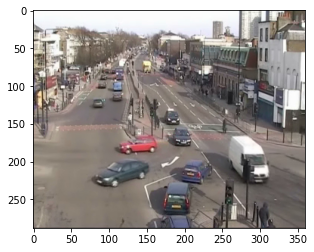

In [39]:
img1 = plt.imread('img1.jpg')
plt.imshow(img1)

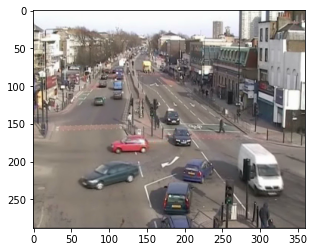

In [40]:
img2 = plt.imread('img2.jpg')
plt.imshow(img2)

In [41]:
radius = 25
img1CenterX = 149.0 # 150 in matlab column
img1CenterY = 174.0 # 175 in matlab row
bins = 16
h = 25
nIter = 25
pixelX = circularNeighbors(img1, img1CenterX, img1CenterY, radius)
q_model = colorHistogram(pixelX, bins,img1CenterX,img1CenterY,h)
print(pixelX.shape)
print(q_model.shape)

(1941, 5)
(16, 16, 16)


In [42]:

def mean_shift_track(nextIm, q_model, r, h, initialX, initialY, nIter, epsilon=-1):
    bins = q_model.shape[0]
    # step 1 generate target pu in current frame at y0
    y0 = np.array([initialX, initialY])
    euclideanDistance = 0
    for iter in range(nIter):
        p_X = circularNeighbors(img2, y0[0], y0[1], r)
        p_test = colorHistogram(p_X, bins, y0[0], y0[1], h)
        # compute weights wi
        w = meanshiftWeights(p_X, q_model, p_test, bins)
        sumW = np.sum(w)
        # now compute next best location of target
        weightedCoordinates = np.zeros(2)
        for i in range(p_X.shape[0]):
            weightedCoordinates+= w[i] * p_X[i,:2]
        # follow the y1 algorithm
        y1 = weightedCoordinates / sumW
        euclideanDistance = np.linalg.norm(y1 - y0)
        y0 = y1
        # stop if y1 - y0 < epsilon, no epsilon here though.
        if epsilon > 0 and euclideanDistance < epsilon:
            return y0, euclideanDistance
    return y0, euclideanDistance
    
    

In [43]:
y_best, dist = mean_shift_track(img2, q_model, radius, h, img1CenterX, img1CenterY, nIter)
print('Final (X,Y):',y_best)
print('Distance:',dist)

Final (X,Y): [139.92090991 173.392098  ]
Distance: 0.008522259691334737


##### As a sanity check, let's see if the red car shows up in 2*radius x 2*radius box around the final center in the second image.

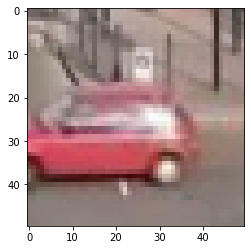

In [44]:
plt.imshow(img2[int(y_best[1]) - radius: int(y_best[1]) + radius, int(y_best[0]) - radius: int(y_best[0]) + radius])

##### Final Discussion: Interestingly enough, the final center position, if you do draw a circle, it does make sense as the original model was of this red car, and cool enough, we see it again using the new center in the second picture. In this case, our final (X,Y)/(col, row) was 139.921, and 173.392 with a small 0.0085 final distance between last two iterations. Also, it is interesting to note that it is not just the front of the car we captured, but also some parts of the roads.